## Prepare Data: Train, Valid, Test

In [26]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns', None)

In [17]:
data = pd.read_csv('data_v4_addtext.csv', index_col = 0)
data.date = data.date.map(lambda x: date(int(x.split("-")[0]), int(x.split("-")[1]), int(x.split("-")[2])))

###### Parameters setting

In [18]:
cut_off_date = datetime(2020,8,15)
cut_off_date_valid = datetime(2020,7,15)
# n_folds = 4

###### Split Train + Cross Valid, VS Test

In [19]:
test_idx = data.date > cut_off_date.date()
print('testing percentage:{:.3f}'.format((test_idx).sum() / len(data.date)))

valid_idx = (data.date <= cut_off_date.date()) & (data.date > cut_off_date_valid.date())
print('testing percentage:{:.3f}'.format((valid_idx).sum() / len(data.date)))
data.drop('date', axis = 1, inplace = True)

testing percentage:0.180
testing percentage:0.160


In [20]:
train_df = data[(test_idx == False) & (valid_idx == False)]
valid_df = data[valid_idx == True]

train_valid_df = data[(test_idx == False)]
test_df = data[test_idx == True]

In [21]:
X_train = train_df.drop('log_play', axis = 1)
y_train = train_df['log_play']

X_valid = valid_df.drop('log_play', axis = 1)
y_valid = valid_df['log_play']

X_train_valid = train_valid_df.drop('log_play', axis = 1)
y_train_valid = train_valid_df['log_play']

X_test = test_df.drop('log_play', axis = 1)
y_test = test_df['log_play']

## Models 

In [22]:
from sklearn.model_selection import train_test_split,KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import xgboost as xgb
import lightgbm as lgb
import shap

from time import time
# ! pip install xgboost / lightgbm / shap

In [48]:
def plot_valid(model, title):
    model.fit(X_train, y_train)

    y_valid_hat = pd.Series(model.predict(X_valid), index = y_valid.index)
    mse = mean_squared_error(y_valid_hat, y_valid)
    r2 = r2_score(y_valid_hat, y_valid)
    valid_idx = y_valid.argsort()
    fig, ax = plt.subplots(figsize = (12, 5))
    plt.plot(y_valid_hat.iloc[valid_idx].values,'.',label = 'real')
    plt.plot(y_valid.iloc[valid_idx].values,'.' ,label = 'model')
    plt.title('{} Valid Plot. mse: {:.2f}, r2:{:.2f}'.format(title, mse, r2))
    plt.ylabel('log-play')
    plt.legend()
    plt.show()

In [49]:
def plot_test(model,title):
    model.fit(X_train_valid, y_train_valid)

    y_test_hat = pd.Series(model.predict(X_test), index = y_test.index)
    mse = mean_squared_error(y_test_hat, y_test)
    r2 = r2_score(y_test_hat, y_test)
    test_idx = y_test.argsort()
    fig, ax = plt.subplots(figsize = (12, 5))
    plt.plot(y_test_hat.iloc[test_idx].values,'.',label = 'real')
    plt.plot(y_test.iloc[test_idx].values,'.' ,label = 'model')
    plt.title('{} Test Plot. mse: {:.2f}, r2:{:.2f}'.format(title, mse, r2))
    plt.ylabel('log-play')
    plt.legend()
    plt.show()

### Light GBM 

#### Tune n_estimators

In [31]:
n_est = range(50,800,50)
# m_feat = range(2,10,2)

mse_valid = []
mse_test = []
r2_valid = []
r2_test = []

for n in n_est:
    lgb_1 = lgb.LGBMRegressor(boosting_type= 'gbdt',#default
                               objective='regression',
                               n_estimators = n
                          )
#                                    , max_depth=m)            
    lgb_1.fit(X_train, y_train, eval_metric = 'r2')
    y_valid_hat = pd.Series(lgb_1.predict(X_valid), index = y_valid.index)
    mse_valid.append(mean_squared_error(y_valid_hat, y_valid))
    r2_valid.append(r2_score(y_valid_hat, y_valid))
    
    y_test_hat = pd.Series(lgb_1.predict(X_test), index = y_test.index)
    mse_test.append(mean_squared_error(y_test_hat, y_test))
    r2_test.append(r2_score(y_test_hat, y_test))

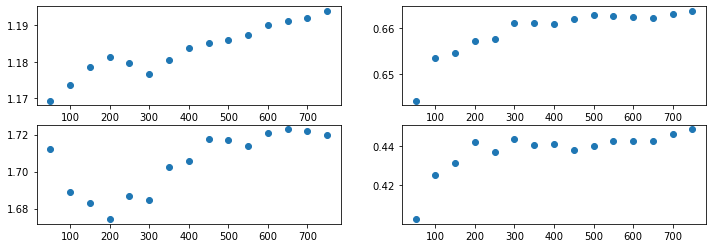

In [32]:
fig, axes  = plt.subplots(2,2,figsize = (12,4))
ax = axes[0][0]
ax.scatter(list(n_est), mse_valid)
ax = axes[0][1]
ax.scatter(list(n_est), r2_valid)
ax = axes[1][0]
ax.scatter(list(n_est), mse_test)
ax = axes[1][1]
ax.scatter(list(n_est), r2_test)
plt.show()

In [34]:
n_est = range(200,400,20)
# m_feat = range(2,10,2)

mse_valid = []
mse_test = []
r2_valid = []
r2_test = []

for n in n_est:
    lgb_1 = lgb.LGBMRegressor(boosting_type= 'gbdt',#default
                              objective='regression',
                              n_estimators = n)          
    lgb_1.fit(X_train, y_train, eval_metric = 'r2')
    y_valid_hat = pd.Series(lgb_1.predict(X_valid), index = y_valid.index)
    mse_valid.append(mean_squared_error(y_valid_hat, y_valid))
    r2_valid.append(r2_score(y_valid_hat, y_valid))
    
    y_test_hat = pd.Series(lgb_1.predict(X_test), index = y_test.index)
    mse_test.append(mean_squared_error(y_test_hat, y_test))
    r2_test.append(r2_score(y_test_hat, y_test))

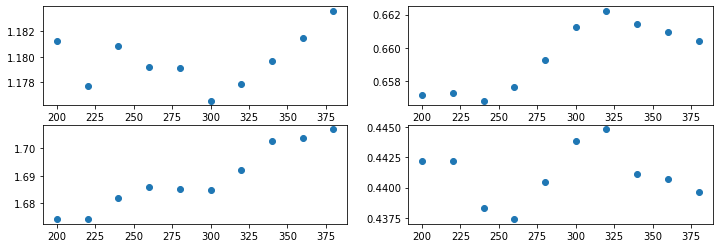

In [36]:
fig, axes  = plt.subplots(2,2,figsize = (12,4))
ax = axes[0][0]
ax.scatter(list(n_est), mse_valid)
ax = axes[0][1]
ax.scatter(list(n_est), r2_valid)
ax = axes[1][0]
ax.scatter(list(n_est), mse_test)
ax = axes[1][1]
ax.scatter(list(n_est), r2_test)
plt.show()

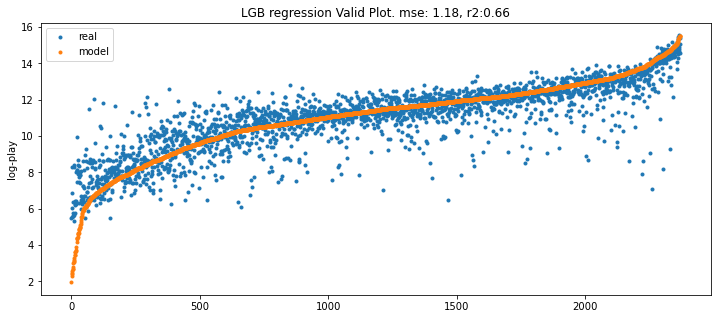

In [50]:
lgb_1 = lgb.LGBMRegressor(boosting_type= 'gbdt',#default
                               objective='regression',
                               n_estimators = 300
                          )
#                                    , max_depth=m)            
lgb_1.fit(X_train, y_train, eval_metric = 'r2')
plot_valid(lgb_1,'LGB regression')

#### Tune max_depth & num_leaves

Smaller values decrease overfitting, num_leaves should be less that 2^max_depth

In [52]:
max_depth = range(2,9,2)
num_leaves = range(5,150,30)
max_depth_s, num_leaves_s = np.meshgrid(max_depth, num_leaves)
max_depth_s = np.ravel(max_depth_s)
num_leaves_s = np.ravel(num_leaves_s)

mse_valid = []
mse_test = []
r2_valid = []
r2_test = []

for n, m  in zip(max_depth_s, num_leaves_s):
    lgb_1 = lgb.LGBMRegressor(boosting_type= 'gbdt',#default
                              objective='regression',
                              n_estimators = 300,
                              max_depth = n,
                              num_leaves = m
                          )           
    lgb_1.fit(X_train, y_train, eval_metric = 'r2')
    y_valid_hat = pd.Series(lgb_1.predict(X_valid), index = y_valid.index)
    mse_valid.append(mean_squared_error(y_valid_hat, y_valid))
    r2_valid.append(r2_score(y_valid_hat, y_valid))
    
    y_test_hat = pd.Series(lgb_1.predict(X_test), index = y_test.index)
    mse_test.append(mean_squared_error(y_test_hat, y_test))
    r2_test.append(r2_score(y_test_hat, y_test))

In [53]:
x_axis = ['{}+{}'.format(max_depth_s[i], num_leaves_s[i])for i in range(len(max_depth_s))]

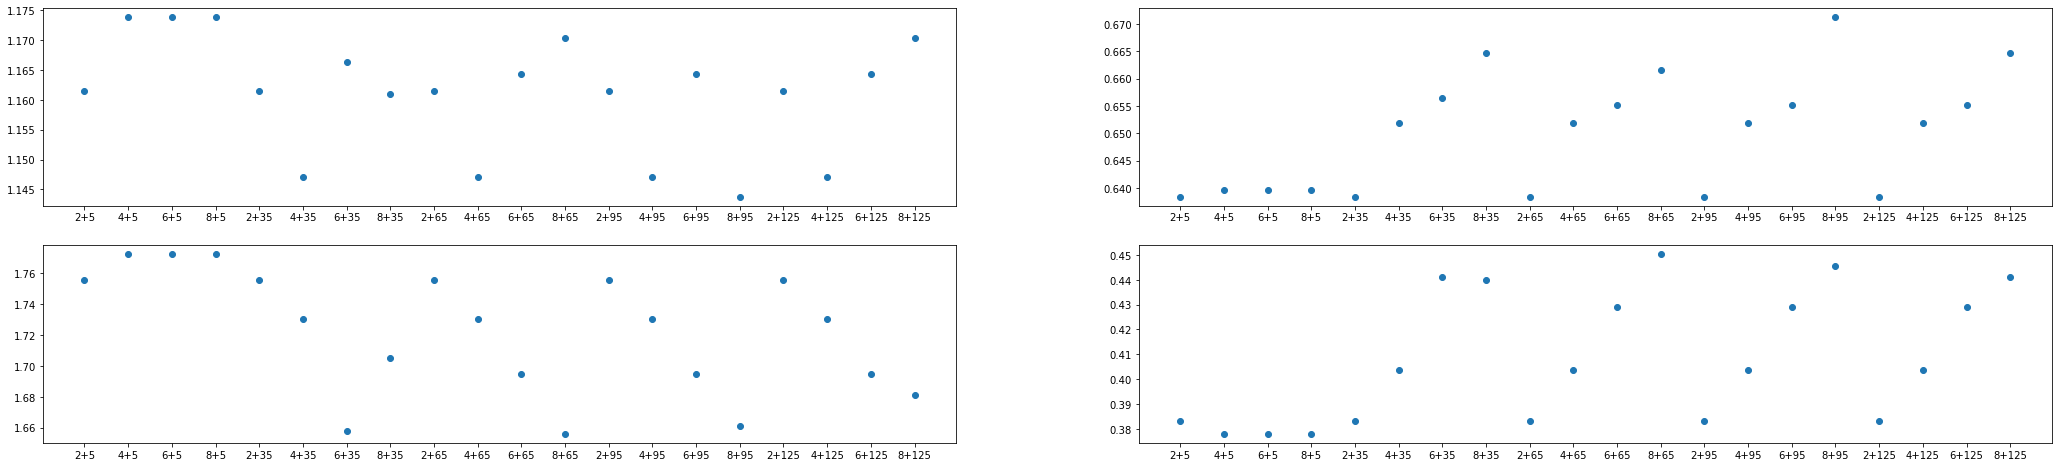

In [54]:
fig, axes  = plt.subplots(2,2,figsize = (36,8))
ax = axes[0][0]
ax.scatter(x_axis, mse_valid)
ax = axes[0][1]
ax.scatter(x_axis, r2_valid)
ax = axes[1][0]
ax.scatter(x_axis, mse_test)
ax = axes[1][1]
ax.scatter(x_axis, r2_test)
plt.show()

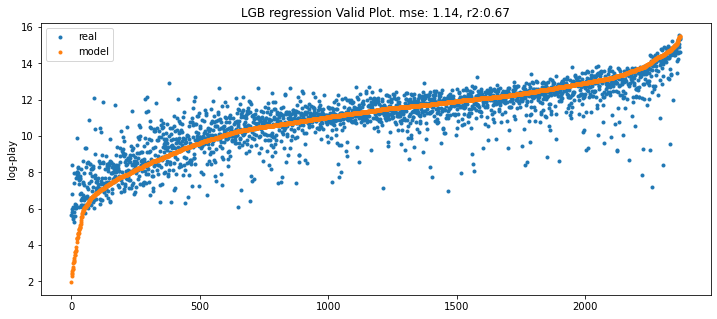

In [80]:
lgb_2 = lgb.LGBMRegressor (boosting_type= 'gbdt',#default
                                     objective='regression',
                                     n_estimators= 300,
                                     max_depth=8,
                                     num_leaves= 95
                                    )
plot_valid(lgb_2,'LGB regression')

In [91]:
print(lgb_2) #when the next time open this notebook, the one didn't have to train

LGBMRegressor(max_depth=8, n_estimators=300, num_leaves=95,
              objective='regression')


#### Compare lgb (Start Here)

In [89]:
lgb_model_tuned = lgb.LGBMRegressor(max_depth=8, 
                                    n_estimators=300, 
                                    num_leaves=95,
                                    objective='regression')

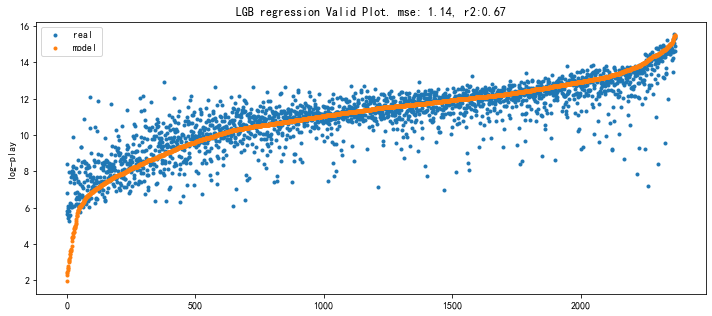

In [102]:
plot_valid(lgb_model_tuned,'LGB regression')

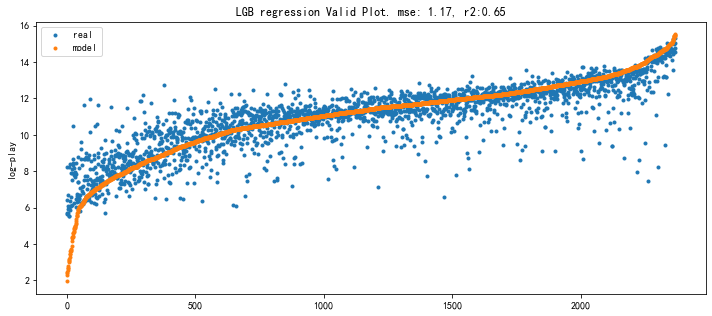

In [103]:
plot_valid(lgb.LGBMRegressor(),'LGB regression')

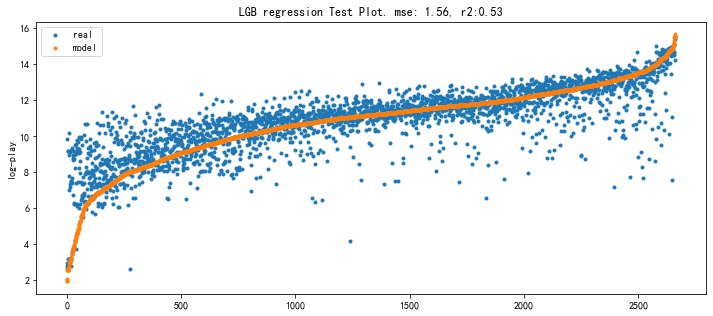

In [108]:
plot_test(lgb_model_tuned,'LGB regression')

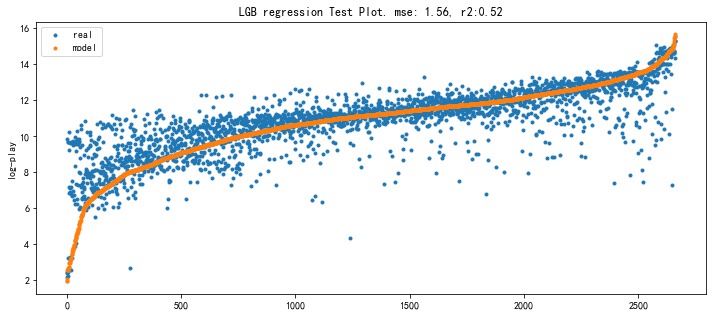

In [109]:
plot_test(lgb.LGBMRegressor(),'LGB regression')

### XGboosting

#### Tune n_estimators

In [77]:
n_est = range(50,800,50)

mse_valid = []
mse_test = []
r2_valid = []
r2_test = []

for n in n_est:
    xgb_1 = xgb.XGBRegressor(n_estimators = n)           
    xgb_1.fit(X_train, y_train)
    y_valid_hat = pd.Series(xgb_1.predict(X_valid), index = y_valid.index)
    mse_valid.append(mean_squared_error(y_valid_hat, y_valid))
    r2_valid.append(r2_score(y_valid_hat, y_valid))
    
    y_test_hat = pd.Series(xgb_1.predict(X_test), index = y_test.index)
    mse_test.append(mean_squared_error(y_test_hat, y_test))
    r2_test.append(r2_score(y_test_hat, y_test))

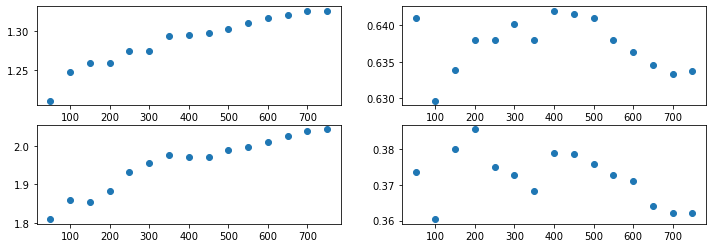

In [79]:
fig, axes  = plt.subplots(2,2,figsize = (12,4))
ax = axes[0][0]
ax.scatter(list(n_est), mse_valid)
ax = axes[0][1]
ax.scatter(list(n_est), r2_valid)
ax = axes[1][0]
ax.scatter(list(n_est), mse_test)
ax = axes[1][1]
ax.scatter(list(n_est), r2_test)
plt.show()

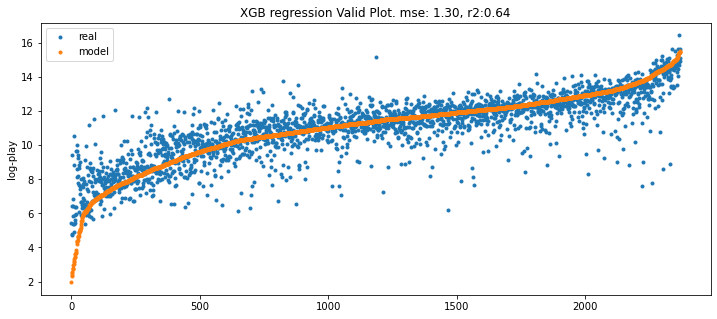

In [81]:
xgb_1 =  xgb.XGBRegressor(n_estimators = 400) 
plot_valid(xgb_1,'XGB regression')

#### Tune max_depth
Smaller values decrease overfitting, num_leaves should be less that 2^max_depth

In [85]:
max_depth = range(3,9,1)

mse_valid = []
mse_test = []
r2_valid = []
r2_test = []

for n in max_depth:
    xgb_2 = xgb.XGBRegressor(n_estimators = 400,
                             max_depth = n)           
    xgb_2.fit(X_train, y_train)
    y_valid_hat = pd.Series(xgb_2.predict(X_valid), index = y_valid.index)
    mse_valid.append(mean_squared_error(y_valid_hat, y_valid))
    r2_valid.append(r2_score(y_valid_hat, y_valid))
    
    y_test_hat = pd.Series(xgb_2.predict(X_test), index = y_test.index)
    mse_test.append(mean_squared_error(y_test_hat, y_test))
    r2_test.append(r2_score(y_test_hat, y_test))

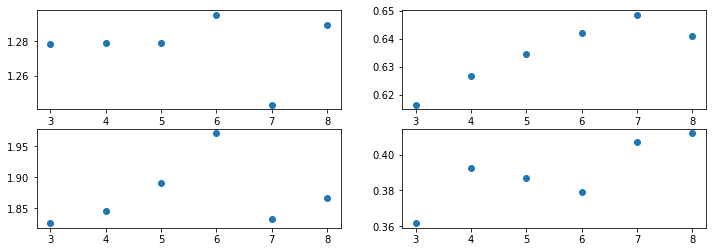

In [86]:
fig, axes  = plt.subplots(2,2,figsize = (12,4))
ax = axes[0][0]
ax.scatter(list(max_depth), mse_valid)
ax = axes[0][1]
ax.scatter(list(max_depth), r2_valid)
ax = axes[1][0]
ax.scatter(list(max_depth), mse_test)
ax = axes[1][1]
ax.scatter(list(max_depth), r2_test)
plt.show()

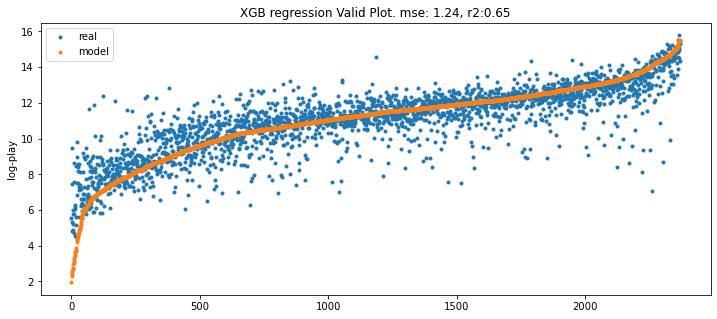

In [90]:
xgb_2 =  xgb.XGBRegressor(n_estimators = 400, max_depth = 7) 
plot_valid(xgb_2,'XGB regression')

In [92]:
print(xgb_2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


#### Compare xgb (Start Here)

In [94]:
xgb_model_tuned  =  xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain', interaction_constraints='',
                                     learning_rate=0.300000012, max_delta_step=0, max_depth=7,
                                     min_child_weight=1, 
                                     n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1, verbosity=None)

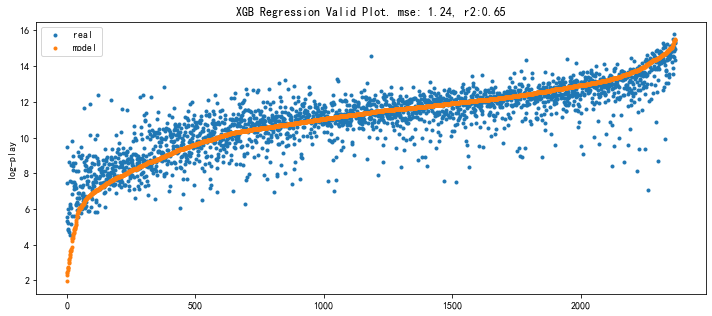

In [104]:
plot_valid(xgb_model_tuned,'XGB Regression')

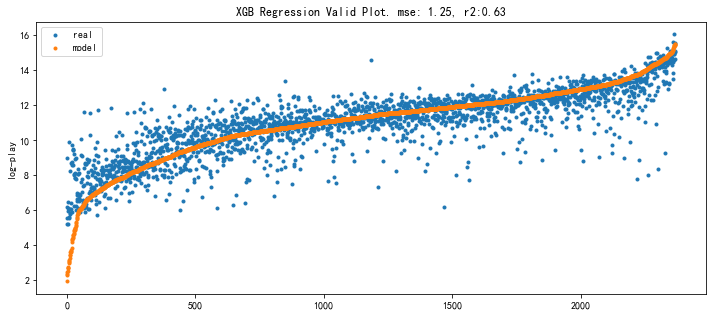

In [105]:
plot_valid(xgb.XGBRegressor(),'XGB Regression')

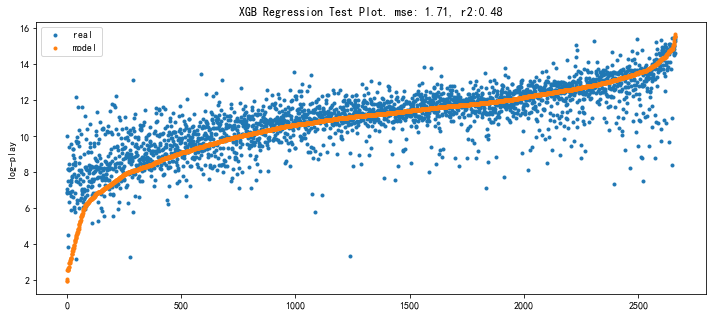

In [106]:
plot_test(xgb_model_tuned,'XGB Regression')

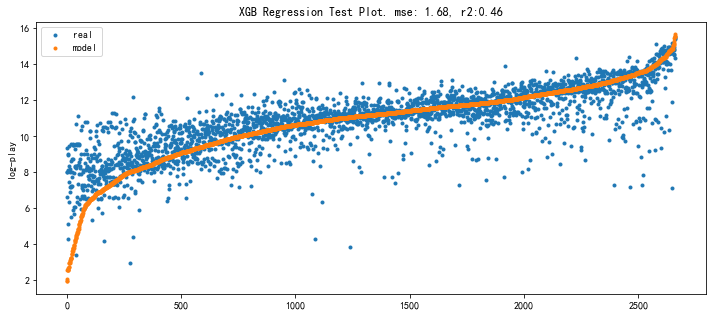

In [107]:
plot_test(xgb.XGBRegressor(),'XGB Regression')

### Feature Importance

In [99]:
plt.rcParams['font.sans-serif']=['SimHei']  # show chinese
plt.rcParams['axes.unicode_minus'] = False  # show positive and negative

In [112]:
lgb_model_tuned.fit(X_train_valid, y_train_valid)
# xgb_model_tuned.fit(X_train_valid, y_train_valid)

LGBMRegressor(max_depth=8, n_estimators=300, num_leaves=95,
              objective='regression')

In [113]:
fi_lgb = lgb_model_tuned.feature_importances_
# fi_xgb = xgb_model_tuned.feature_importances_

In [114]:
def plot_top_features(feature_importance, title, features = X_train_valid.columns, top = 10):
    fig, ax = plt.subplots(figsize = (top, 6))
    top_index = feature_importance.argsort()[::-1][:top]
    plt.plot(feature_importance[top_index])
    plt.xticks(range(top),features[top_index], rotation = 45)
    plt.title(title)
    plt.show()

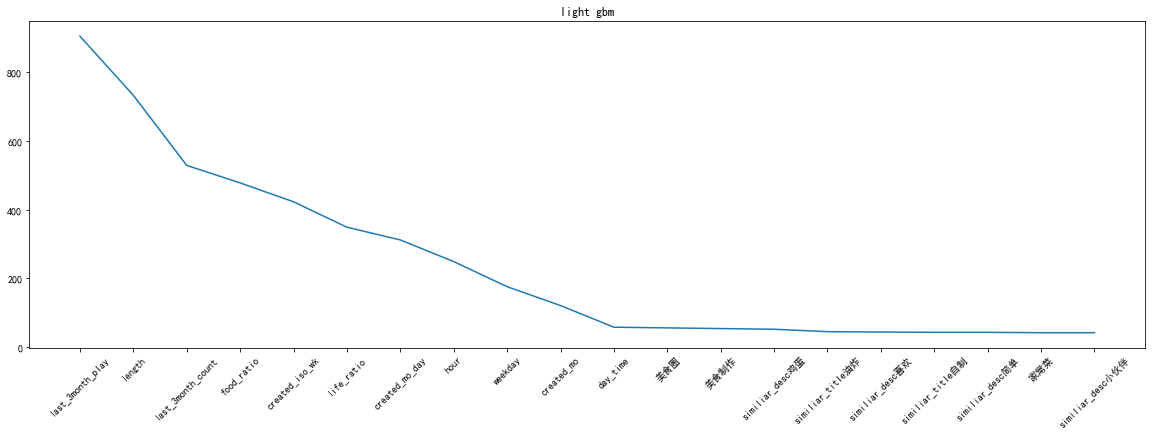

In [115]:
plot_top_features(fi_lgb, 'light gbm', top = 20)
# plot_top_features(fi_xgb, 'xg boosting', top = 20)

### SHAP

#### SHAP for All Up Loader

In [138]:
y_test_hat = pd.Series(lgb_model_tuned.predict(X_test), index = y_test.index)

In [129]:
explainer = shap.TreeExplainer(lgb_model_tuned,shap.sample(X_train_valid,800))

test_shap=explainer.shap_values(X_test)

 99%|===================| 2644/2663 [00:21<00:00]        

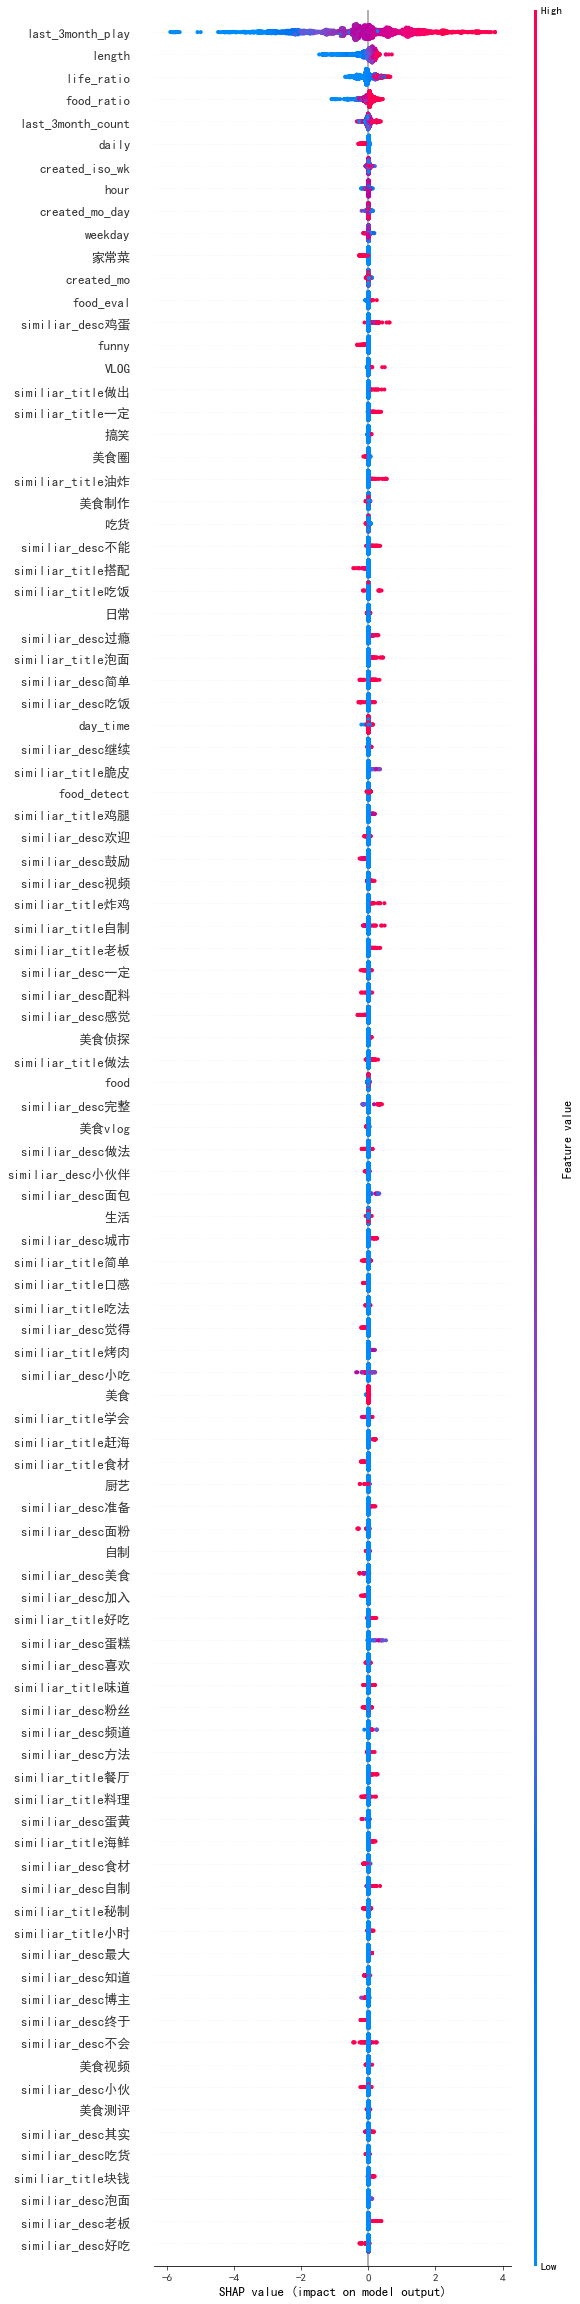

In [130]:
p=shap.summary_plot(test_shap,X_test,show=False, max_display = 100)

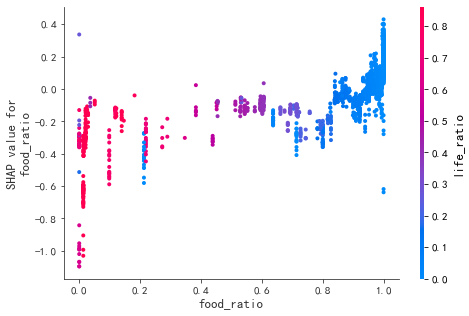

In [131]:
p = shap.dependence_plot('food_ratio', test_shap, X_test, interaction_index='life_ratio')
p

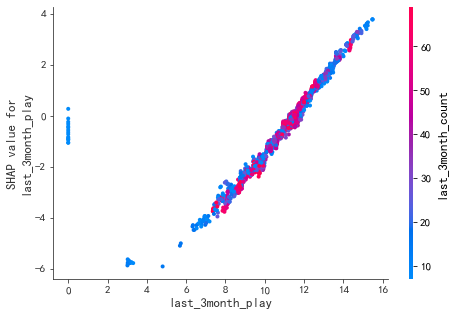

In [132]:
p = shap.dependence_plot('last_3month_play', test_shap, X_test, interaction_index='last_3month_count')
p

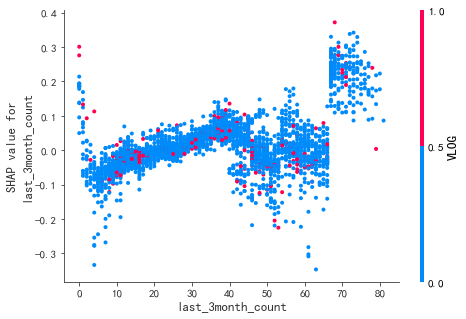

In [133]:
p = shap.dependence_plot('last_3month_count', test_shap, X_test, interaction_index='VLOG')
p

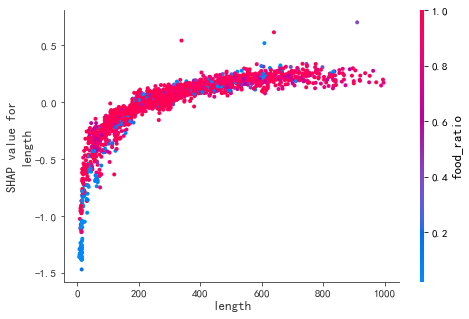

In [134]:
p = shap.dependence_plot('length', test_shap, X_test, interaction_index='food_ratio')
p

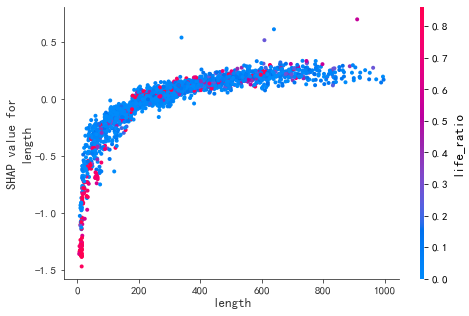

In [135]:
p = shap.dependence_plot('length', test_shap, X_test, interaction_index='life_ratio')
p

In [155]:
def plot_one_shap(num):
    print('Real play: {:d}, Model play: {:d}, Base play: {:d}'.format(int(np.exp(y_test.iloc[num])),
                                                                       int(np.exp(y_test_hat.iloc[num])),
                                                                       int(np.exp(X_test.iloc[num]['last_3month_play']))
                                                                      ))
    print('Real play: {:.2f}, Model play: {:.2f}, Base play: {:.2f}'.format(y_test.iloc[num],
                                                                       y_test_hat.iloc[num],
                                                                       X_test.iloc[num]['last_3month_play']
                                                                      ))
    p = shap.force_plot(explainer.expected_value, test_shap[num], X_test.iloc[num].map(lambda x: np.round(x, 2)),
                        matplotlib=True,show=False)

Real play: 1627073, Model play: 2805534, Base play: 3812078
Real play: 14.30, Model play: 14.85, Base play: 15.15


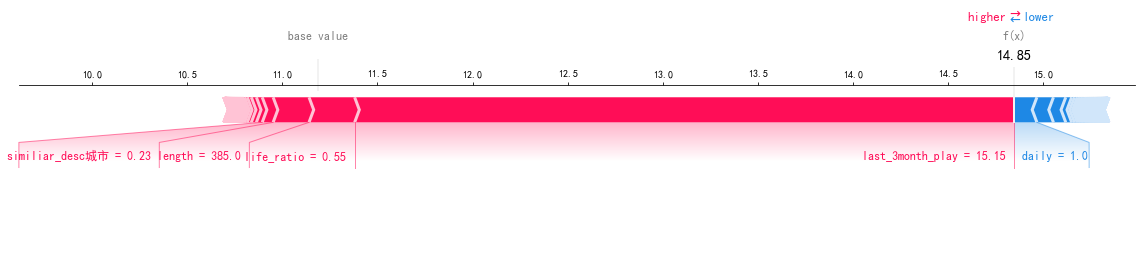

In [156]:
plot_one_shap(1)

Real play: 9329, Model play: 31460, Base play: 44110
Real play: 9.14, Model play: 10.36, Base play: 10.69


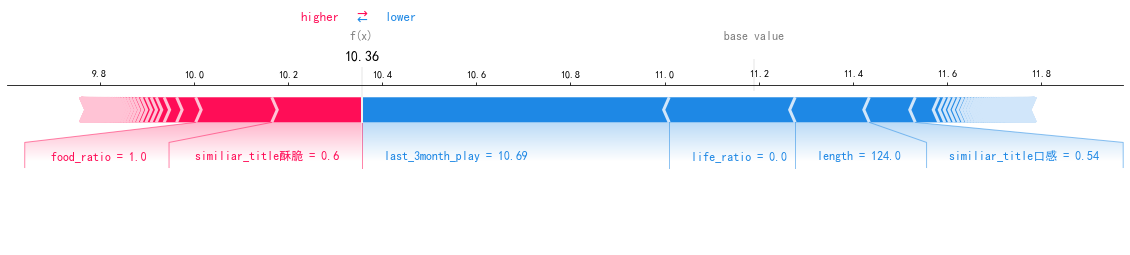

In [159]:
plot_one_shap(11)

Real play: 175017, Model play: 332201, Base play: 303977
Real play: 12.07, Model play: 12.71, Base play: 12.62


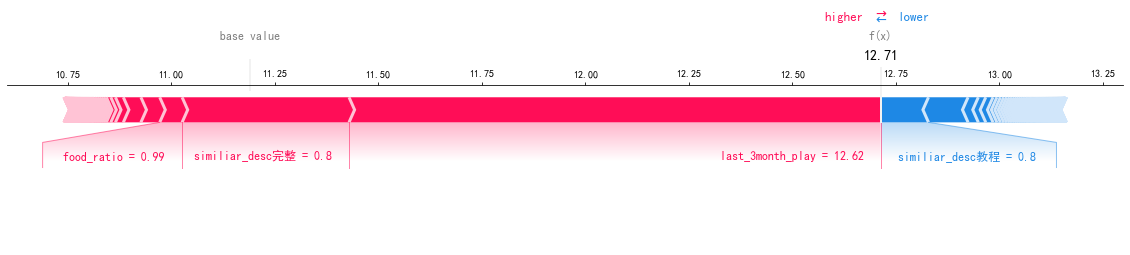

In [160]:
plot_one_shap(111)

#### SHAP for one UP Loader

In [ ]:
someone ??

In [ ]:
explainer = shap.TreeExplainer(lgb_model_tuned,shap.sample(someone,800))

someone_shap = explainer.shap_values(someone)